## Implement Linear Regression

use the dataframe we got to find which parameters are the most relevant to make a game successful.

## get the genre for the games

import our data and get the genre for the games

In [2]:
# our imports first 
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import requests
import json



In [58]:
#| label: initial-column-list

# read the data from file that we created trough 'all' query to the steamspy api 
data = pd.read_csv('df_all_games.csv')

#print(data.head(10).to_markdown())

print(data.columns.to_list())

['appid', 'name', 'developer', 'publisher', 'score_rank', 'positive', 'negative', 'userscore', 'owners', 'average_forever', 'average_2weeks', 'median_forever', 'median_2weeks', 'price', 'initialprice', 'discount', 'ccu']


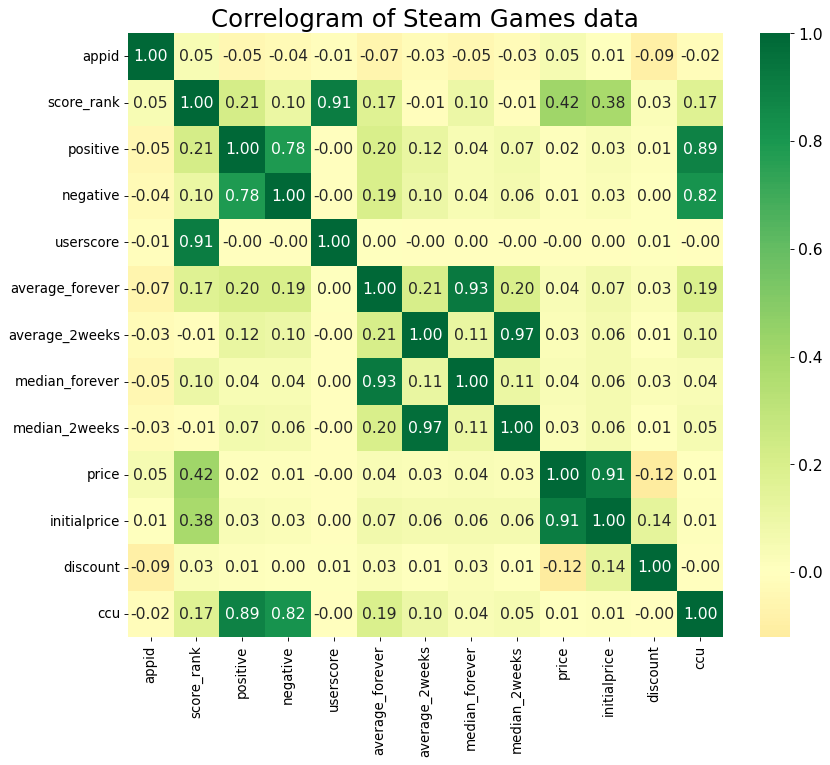

In [64]:
#| echo: false
#| label: fig-correlation-matrix
#| fig-cap: "Correlation matrix of the steam games dataset"


import matplotlib.pyplot as plt
import seaborn as sns

# plot the correlation matrix
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(data.corr(), xticklabels=data.corr().columns, yticklabels=data.corr().columns, cmap='RdYlGn', center=0, annot=True, fmt=".2f")

# decoration
plt.title('Correlogram of Steam Games data', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [88]:


# clean 
df_genres = data.copy()
df_genres = df_genres.drop(['score_rank','initialprice','discount','userscore'],axis=1)
df_genres['appid'] = df_genres['appid'].astype(int)

# get the average of the owners
owners = pd.DataFrame(df_genres['owners'].str.replace(',','').str.split(' .. ').tolist(),columns = ['min','max'])
df_genres['owners']= owners.astype(int).sum(axis=1)/2
df_genres['owners'] = df_genres['owners'].astype(int)
df_genres.rename(columns={'owners':'avg_owners'},inplace=True)

# ratio of positive reviews over total reviews
df_genres['positive_ratio'] = df_genres['positive']/(df_genres['positive']+df_genres['negative'])

'''
REMARK: this ratio is severely skewed when the number of reviews is low.
'''

# lets drop the rows with less than 100 reviews and 0 average concurent players 
df_genres = df_genres[((df_genres['positive']+df_genres['negative'])>100) & (df_genres['average_forever']>0)]
# only 12k rows left


In [89]:
#| echo: false
#| label: modified-initial-data
print(pd.DataFrame(df_genres.columns.to_list(), columns=['Columns']))

            Columns
0             appid
1              name
2         developer
3         publisher
4          positive
5          negative
6        avg_owners
7   average_forever
8    average_2weeks
9    median_forever
10    median_2weeks
11            price
12              ccu
13   positive_ratio


In [ ]:
#| echo: true
#| label: code-genre-iteration
#function to get list of games of a genre by giving genre

# the different genres available
genres = ['Action','Strategy','RPG','Indie','Adventure','Sports','Simulation','Early+Access','Ex+Early+Access','Massively','Free']

def get_games_by_genre(genre):
    # get the list of appids for games in genre
    url = f'https://steamspy.com/api.php?request=genre&genre={genre}'
    response = requests.get(url)
    response = json.loads(response.text)
    genre_df = json_normalize(response,max_level=0)
    genre_df = pd.DataFrame(response)
    genre_df = genre_df.transpose()
    genre_df = genre_df.reset_index(drop=True)
    return genre_df

#iterate trough games and obtain dummy variable columns for each genre
not_matched = 0
for genre in genres: 
    df_genres[f'{genre}'] = 0
    df_genres[f'{genre}'][df_genres['appid'].astype(int).isin(get_games_by_genre(f'{genre}')['appid'])] = 1

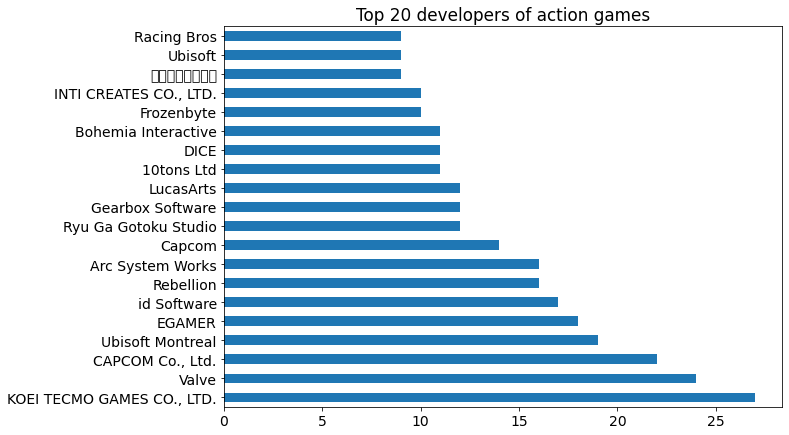

In [75]:
#| label: fig-Top-20-developers-of-action-games
#| fig-cap: "Top 20 developers of action games"

df_genres = pd.read_csv('df_genres.csv')
df_genres['developer'][df_genres['genre_Action']==1].value_counts().head(20).plot.barh(figsize=(10,7),title='Top 20 developers of action games');


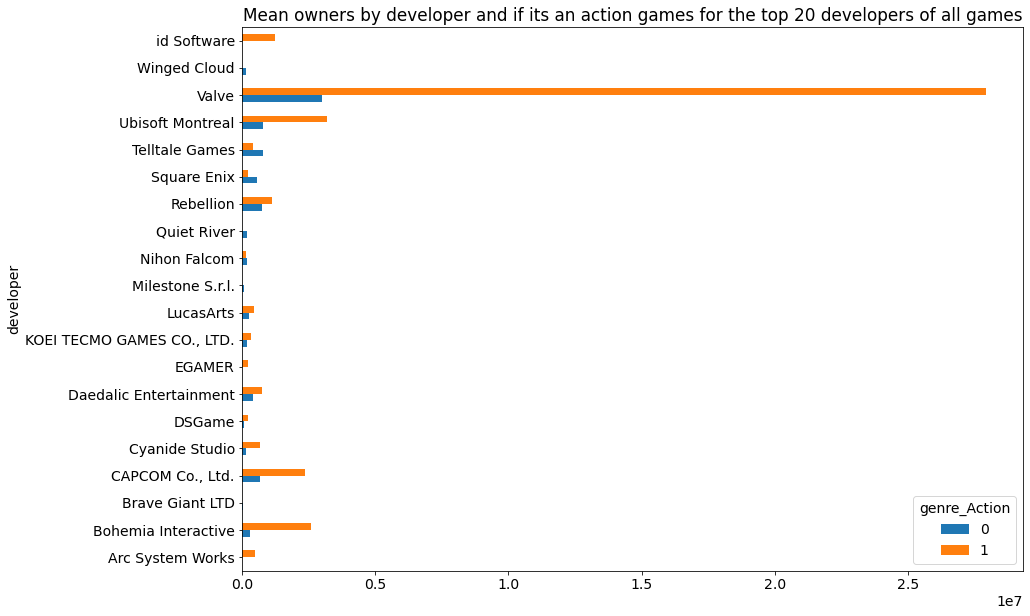

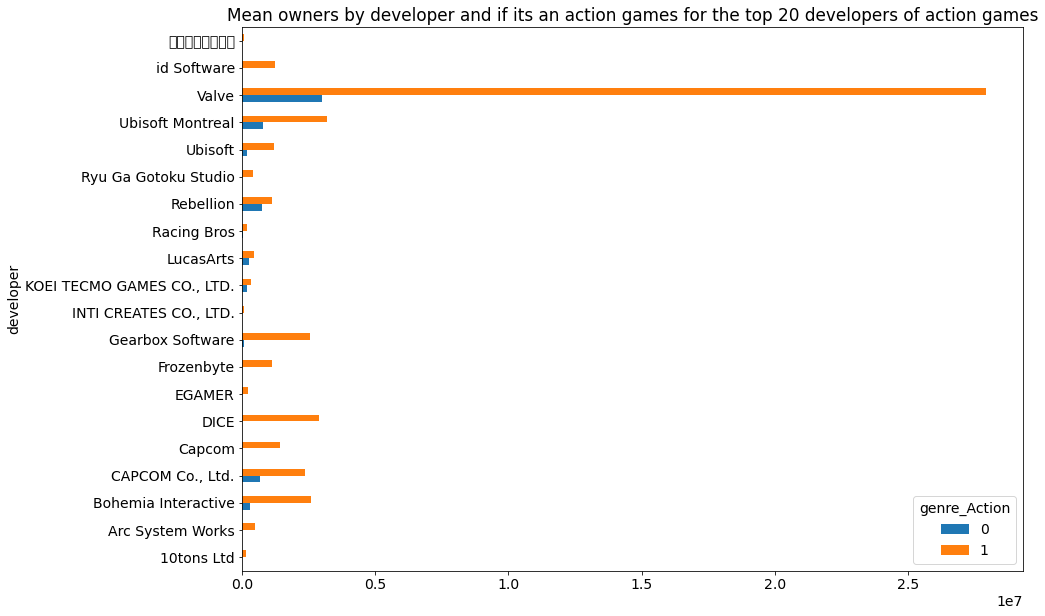

In [79]:
#| layout: [45,-10, 45]
#| label: fig-Pivot-tables-Dev-Action
#| fig-cap: 
#|   - "Mean owners by developer and if its an action games for the top 20 developers of all games"
#|   - "Mean owners by developer and if its an action games for the top 20 developers of action games"

df_genres[df_genres['developer'].isin(df_genres['developer'].value_counts().head(20).index.to_list())].pivot_table(index='developer',columns='genre_Action',values='avg_owners',aggfunc=np.mean,fill_value=0).plot.barh(figsize=(14,10),title='Mean owners by developer and if its an action games for the top 20 developers of all games');
df_genres[df_genres['developer'].isin(df_genres['developer'][df_genres['genre_Action']==1].value_counts().head(20).index.to_list())].pivot_table(index='developer',columns='genre_Action',values='avg_owners',aggfunc=np.mean,fill_value=0).plot.barh(figsize=(14,10),title='Mean owners by developer and if its an action games for the top 20 developers of action games');

# from these two graphs it does seem like action games are more popular than other genres.


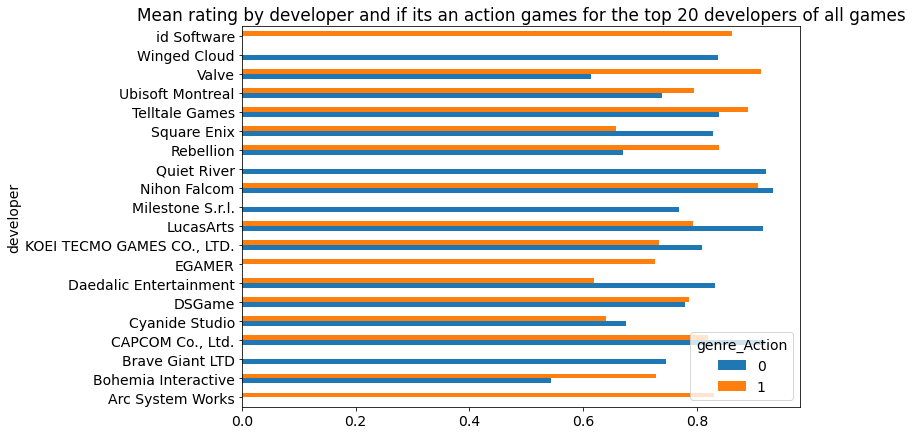

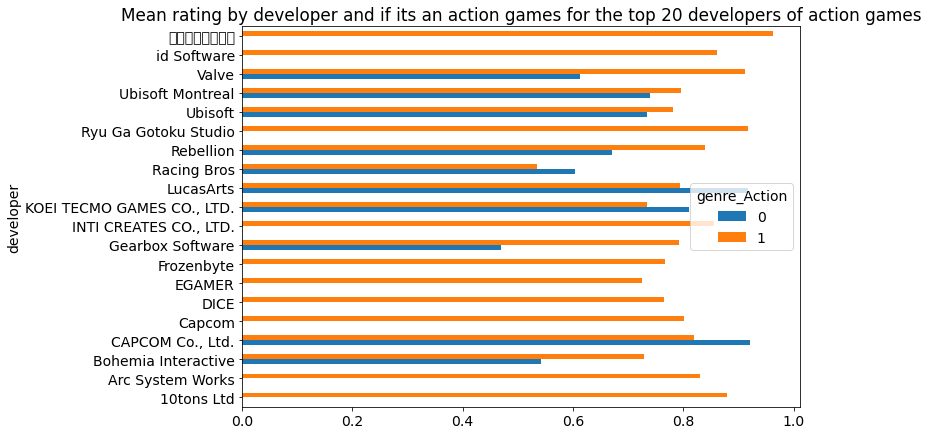

In [83]:
#| layout: [40,-10, 40]
#| label: fig-Pivot-tables-Dev-Rating
#| fig-cap: 
#|   - "Mean rating by developer and if its an action games for the top 20 developers of all games"
#|   - "Mean rating by developer and if its an action games for the top 20 developers of action games"


# lets look at their ratings 

df_genres[df_genres['developer'].isin(df_genres['developer'].value_counts().head(20).index.to_list())].pivot_table(index='developer',columns='genre_Action',values='positive_ratio',aggfunc=np.mean,fill_value=0).plot.barh(figsize=(10,7),title='Mean rating by developer and if its an action games for the top 20 developers of all games');
df_genres[df_genres['developer'].isin(df_genres['developer'][df_genres['genre_Action']==1].value_counts().head(20).index.to_list())].pivot_table(index='developer',columns='genre_Action',values='positive_ratio',aggfunc=np.mean,fill_value=0).plot.barh(figsize=(10,7),title='Mean rating by developer and if its an action games for the top 20 developers of action games');


# the rating seem kinda random 


In [117]:
#df_genres[df_genres['developer'].isin(df_genres['developer'].value_counts().head(20).index.to_list())].pivot_table(index='developer',columns='genre_Free',values='avg_owners',aggfunc=np.mean,fill_value=0).plot.barh(figsize=(10,7),title='Mean owners by devoloper and if its an action games for the top 20 developers of all games')
#df_genres[df_genres['developer'].isin(df_genres['developer'][df_genres['genre_Free']==1].value_counts().head(20).index.to_list())].pivot_table(index='developer',columns='genre_Free',values='avg_owners',aggfunc=np.mean,fill_value=0).plot.barh(figsize=(10,7),title='Mean owners by devoloper and if its an action games for the top 20 developers of action games')

df_genres['developer'][df_genres['genre_Free']==1].value_counts()

'''
not enough data to make a conclusion for the free games 

'''

L. Stotch              7
Gameloft               7
upjers                 6
Home Net Games         4
Gravity Interactive    4
                      ..
Kokua Games            1
Acute Games            1
DONTNOD ELEVEN         1
Soleil Ltd.            1
Ovilex Software        1
Name: developer, Length: 922, dtype: int64

## Implement Linear Regression

In [100]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [101]:
df_genres = pd.read_csv('df_genres.csv')
df_genres = df_genres.drop(['Unnamed: 0'],axis=1)

#independent variables list 
_Indep_var = [
       'ccu', 'average_forever','price',  'positive_ratio', 'genre_Action',
       'genre_Strategy', 'genre_RPG', 'genre_Indie', 'genre_Adventure',
       'genre_Sports', 'genre_Simulation', 'genre_Early+Access',
       'genre_Ex+Early+Access', 'genre_Massively', 'genre_Free'
       ]

#dependable var 
_Dep_var = 'avg_owners'

#split the data into train and test
X_train,X_test,Y_train, Y_test = train_test_split(df_genres[_Indep_var],df_genres[_Dep_var], test_size=0.2, random_state=42)

# see name of columns
df_genres.columns

Index(['appid', 'name', 'developer', 'publisher', 'positive', 'negative',
       'avg_owners', 'average_forever', 'average_2weeks', 'median_forever',
       'median_2weeks', 'price', 'ccu', 'positive_ratio', 'genre_Action',
       'genre_Strategy', 'genre_RPG', 'genre_Indie', 'genre_Adventure',
       'genre_Sports', 'genre_Simulation', 'genre_Early+Access',
       'genre_Ex+Early+Access', 'genre_Massively', 'genre_Free'],
      dtype='object')

In [102]:


# Create a linear regression object
reg = LinearRegression()

# Fit the regression model using the dataset
reg.fit(X_train, Y_train)

# Print the coefficients of the model
print('list of value of different coefficients : ' , reg.coef_.round(2).tolist())
print('the intercept is : ', reg.intercept_.round(2))


# Make predictions using the model
y_pred = reg.predict(X_test)



list of value of different coefficients :  [118.08, 57.83, 60.26, 1174105.51, 382206.32, -64007.75, 51844.04, -359951.03, -7097.97, -82927.44, 20147.18, -168302.8, 130808.98, 561195.74, 565761.0]
the intercept is :  -548518.02


### Statistics of the regression model

In [103]:
from sklearn.metrics import mean_squared_error, r2_score

# Get the R-squared value
print('the r-squared is : ', r2_score(Y_test, y_pred))

# Get the mean squared error
print('the mean square error is : ',mean_squared_error(Y_test, y_pred))

# Get the root mean squared error
print('where as the root mean square error is : ', np.sqrt(mean_squared_error(Y_test, y_pred)))

the r-squared is :  0.35757818141534026
the mean square error is :  36474167775568.336
where as the root mean square error is :  6039384.718294433


## make some plots

/Users/simondeshayes/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


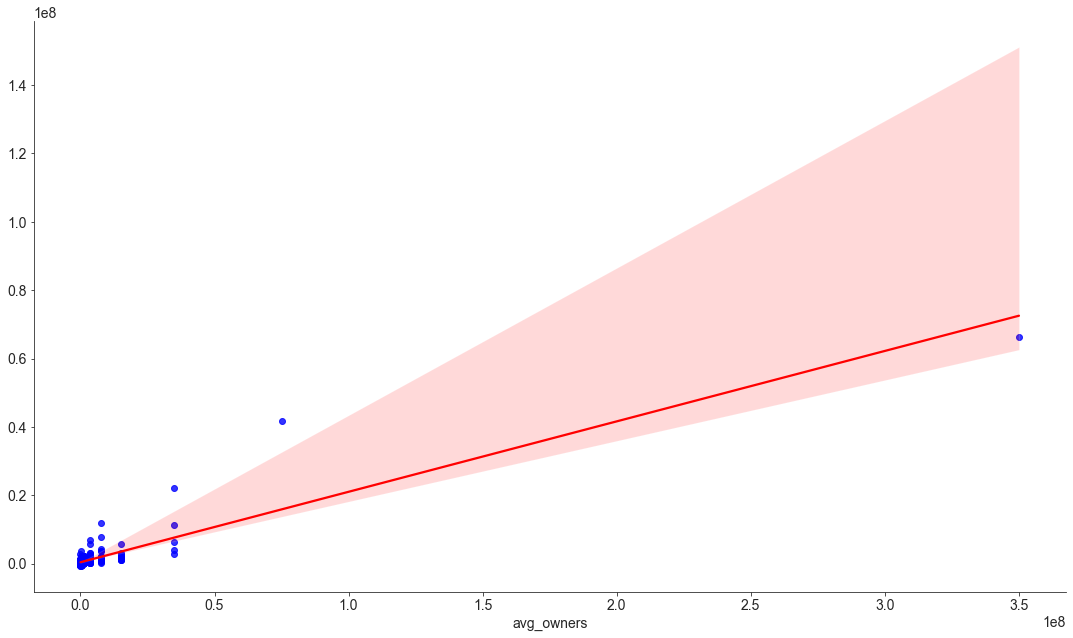

In [104]:
#| label: fig-Ols-gen-avg-owners
#| fig-cap: "OLS predicting the average owners"

import seaborn as sns

sns.set_style('ticks')

g = sns.regplot(Y_test, y_pred, data=df_genres, scatter_kws={"color": "blue"}, line_kws={"color": "red"});
g.figure.set_size_inches(18.5, 10.5)
sns.despine()


#sns.scatterplot(Y_test, y_pred)

# we will try with another library 
model with ccu as output but with statsmodels

In [105]:
#| label: tbl-ols-regression
#| tbl-cap: "OLS regression Statistics"

import statsmodels.api as sm
from statsmodels.formula.api import ols

df_genres = pd.read_csv('df_genres.csv')

df_genres = df_genres.drop(['Unnamed: 0'],axis=1)

#independent variables list 
_Indep_var = [
       'avg_owners', 'average_forever','price',  'positive_ratio', 'genre_Action',
       'genre_Strategy', 'genre_RPG', 'genre_Indie', 'genre_Adventure',
       'genre_Sports', 'genre_Simulation', 'genre_Early+Access',
       'genre_Ex+Early+Access', 'genre_Massively', 'genre_Free'
       ]

#dependable var 
_Dep_var = 'ccu'

X = df_genres[_Indep_var]
y = df_genres[_Dep_var]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Add a constant to the independent variables matrix for the intercept
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the linear regression model on the training set
model = sm.OLS(y_train, X_train).fit()

# Predict the dependent variable on the test set using the fitted model
y_pred = model.predict(X_test)

# Print the summary of the model
model.summary()

/Users/simondeshayes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ccu   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     503.3
Date:                Sun, 26 Mar 2023   Prob (F-statistic):               0.00
Time:                        18:17:30   Log-Likelihood:            -1.0326e+05
No. Observations:                9728   AIC:                         2.066e+05
Df Residuals:                    9712   BIC:                         2.067e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   381.9284    596.857      0.640      0.522    -788.035    1551.892
avg_owners                0.0019   2.36e-05     81.481      0.000       0.002       0.002
average_forever           0.3442      0.035      9.708      0.000       0.275       0.414
price                     0.1097      0.135      0.814      0.416      -0.154       0.374
positive_ratio        -1475.0707    681.939     -2.163      0.031   -2811.813    -138.328
genre_Action           -239.9570    213.746     -1.123      0.262    -658.943     179.029
genre_Strategy         -237.6275    251.342     -0.945      0.344    -730.310     255.055
genre_RPG              -302.0724    244.462     -1.236      0.217    -781.269     177.124
genre_Indie             174.1828    219.875      0.792      0.428    -256.818     605.184
genre_Adventure         136.7784    214.229      0.638      0.523    -283.156     556.712
genre_Sports            -20.6869    494.272     -0.042      0.967    -989.562     948.188
genre_Simulation         48.8558    254.797      0.192      0.848    -450.599     548.311
genre_Early+Access      -10.8090    409.580     -0.026      0.979    -813.670     792.052
genre_Ex+Early+Access    76.7635    337.380      0.228      0.820    -584.572     738.099
genre_Massively       -1302.0442    536.625     -2.426      0.015   -2353.941    -250.147
genre_Free              862.0251    397.522      2.168      0.030      82.799    1641.251
==============================================================================
Omnibus:                    34239.356   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      14137265604.131
Skew:                          68.569   Prob(JB):                         0.00
Kurtosis:                    5907.178   Cond. No.                     3.93e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.93e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/Users/simondeshayes/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


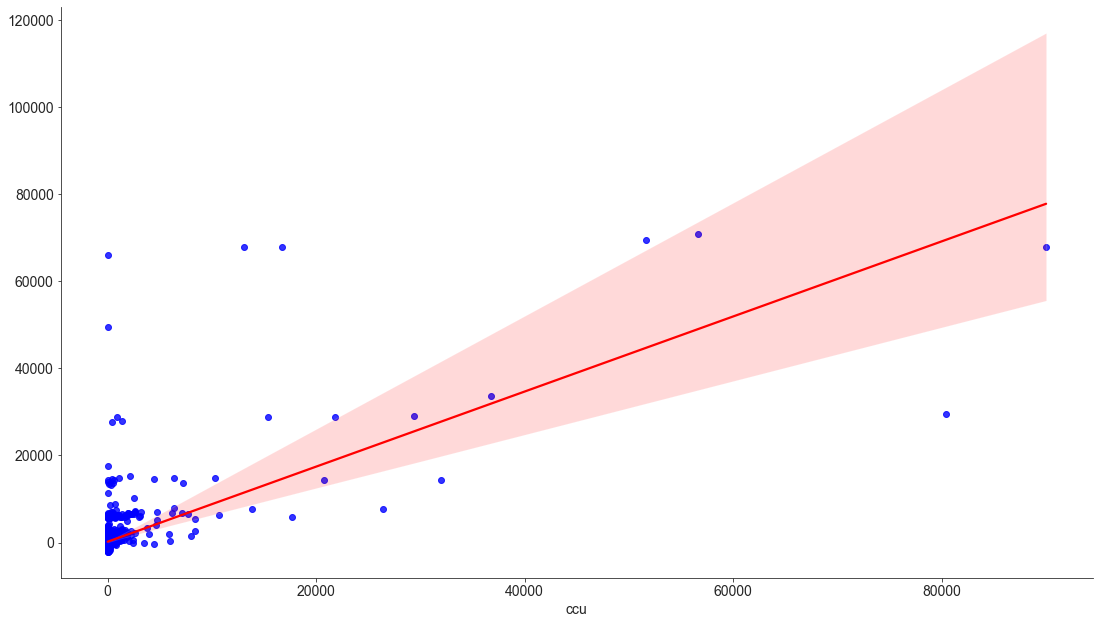

In [106]:
#| label: fig-Ols-gen-ccu
#| fig-cap: "OLS predicting the concurent players count"


# plot
sns.set_style('ticks')

g = sns.regplot(y_test, y_pred, data=df_genres, scatter_kws={"color": "blue"}, line_kws={"color": "red"});
g.figure.set_size_inches(18.5, 10.5)
sns.despine()

# lets try different approaches 

In [114]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

dev_data = pd.read_csv('df_genres.csv')
dev_data = dev_data.drop(['Unnamed: 0'],axis=1)

# tried the models with the top 20 developers by number of games and the top 20 developers by number of games in the action genre
# but the were not different than using the whole dataset so i decided to use the whole dataset

'''

# top 20 developers by number of games
best_dev_data = dev_data[dev_data['developer'].isin(dev_data['developer'].value_counts().head(20).index.to_list())].copy()
best_dev_data = best_dev_data.set_index('developer')
# top 20 developers by number of games in the action genre
bestAction_dev_data = dev_data[dev_data['developer'].isin(dev_data['developer'][dev_data['genre_Action']==1].value_counts().head(20).index.to_list())].copy()
bestAction_dev_data = bestAction_dev_data.set_index('developer')

'''

dev_model = ols("avg_owners ~ average_forever + positive_ratio*positive ", data=bestAction_dev_data).fit()


In [115]:
#| label: tbl-ols-best 
#| tbl-cap: "OLS regression Statistics for best model yet"
dev_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_owners   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     387.3
Date:                Sun, 26 Mar 2023   Prob (F-statistic):          9.11e-126
Time:                        18:35:05   Log-Likelihood:                -6037.7
No. Observations:                 348   AIC:                         1.209e+04
Df Residuals:                     343   BIC:                         1.210e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -4.2e+06   2.65e+06     -1.585      0.114   -9.41e+06    1.01e+06
average_forever           233.5738    268.621      0.870      0.385    -294.778     761.926
positive_ratio           4.469e+06    3.3e+06      1.356      0.176   -2.02e+06     1.1e+07
positive                  860.2547     61.291     14.036      0.000     739.702     980.808
positive_ratio:positive  -839.6126     67.867    -12.371      0.000    -973.100    -706.125
==============================================================================
Omnibus:                      367.449   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            93099.977
Skew:                          -3.799   Prob(JB):                         0.00
Kurtosis:                      82.768   Cond. No.                     1.56e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

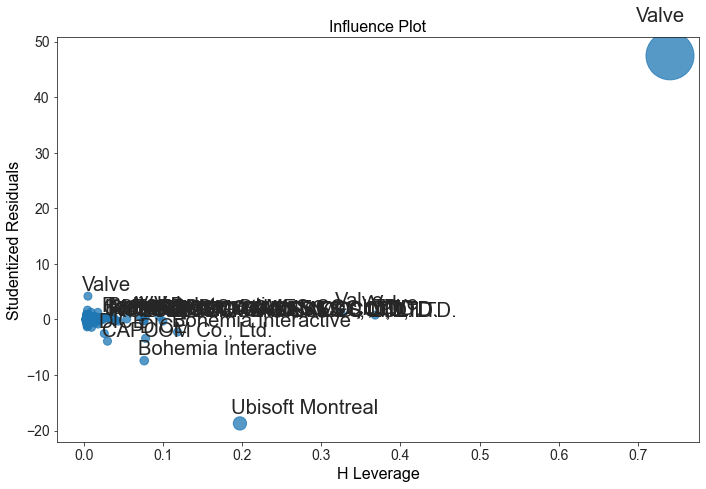

In [125]:
#| label: fig-Ols-best-1
#| fig-cap: "OLS Influence plot"
fig = sm.graphics.influence_plot(dev_model, criterion="cooks");
fig.figure.set_size_inches(10, 7)
fig.tight_layout(pad=1.0)


#the influence plot shows the same result for both the models

#basically the most influential developer is valve


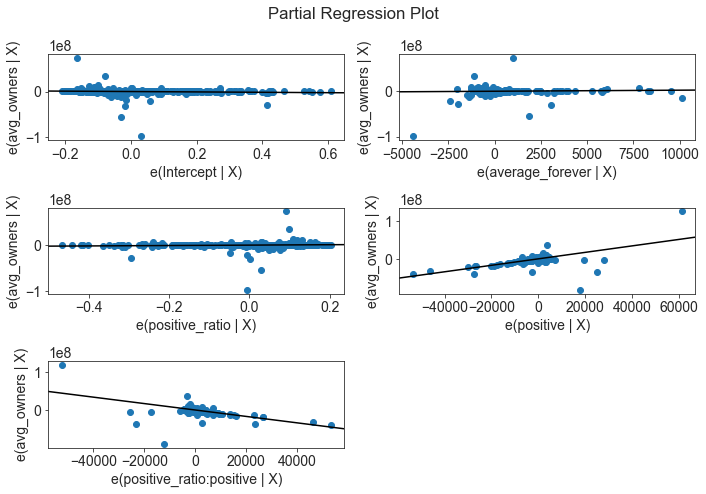

In [126]:
#| label: fig-Ols-best-2
#| fig-cap: "OLS partial Regression plot"
plt.rc("figure", figsize=(10, 7))
plt.rc("font", size=14)

fig = sm.graphics.plot_partregress_grid(dev_model)
fig.tight_layout(pad=1.0)

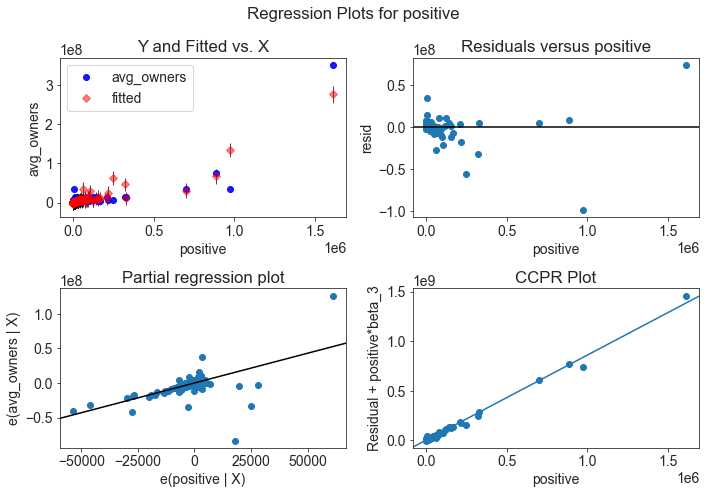

In [127]:
#| label: fig-Ols-best-3
#| fig-cap: "Regression plot for num of positve reviews"
plt.rc("figure", figsize=(10, 7))
fig = sm.graphics.plot_regress_exog(dev_model, "positive")
fig.tight_layout(pad=1.0)